# Likelihood-free inference using Bayesian neural network 

In [1]:
from sciope.models.bnn_classifier import BNNModel
from sciope.utilities.priors.uniform_prior import UniformPrior
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

#in case CUDA is causing problems...
tf.config.set_visible_devices([], 'GPU')

## MA2 Simulator

In [3]:
def simulator(param, n=100):
    """
    Simulate a given parameter combination.

    Parameters
    ----------
    param : vector or 1D array
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    m = len(param)
    g = np.random.normal(0, 1, n)
    gy = np.random.normal(0, 0.3, n)
    y = np.zeros(n)
    x = np.zeros(n)
    for t in range(0, n):
        x[t] += g[t]
        for p in range(0, np.minimum(t, m)):
            x[t] += g[t - 1 - p] * param[p]
        y[t] = x[t] + gy[t]
    
    return np.reshape(y, (1,1,100))

## Create synthetic data

In [4]:
obs_data = simulator([0.6,0.2]) 

In [5]:
obs_data = np.transpose(obs_data, (0,2,1))

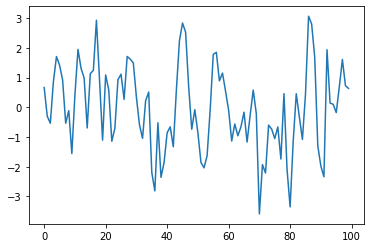

In [6]:
plt.plot(obs_data[0])

## Define initial prior

In [7]:
parameter_names = ['k1', 'k2']

lower_bounds = [-2, -1]
upper_bounds = [2, 1]

prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Perform parameter inference using BNN classifier

In [162]:
from sciope.inference.bnn_inference import BNNClassifier

bnn = BNN(obs_data, simulator, prior, num_bins=4)

In [163]:
post = bnn.infer(num_samples=3000, num_rounds=6, chunk_size=10)

Epoch 00069: early stopping
Epoch 00100: early stopping
Epoch 00067: early stopping
Epoch 00068: early stopping
Epoch 00062: early stopping
Epoch 00067: early stopping


In [135]:
import matplotlib.pyplot as plt

def plot_posterior(posterior):
    true_params = [0.6, 0.2]
    fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1], facecolor = 'w')
    for i in range(posterior.shape[1]):
        for j in range(posterior.shape[1]):
            if i > j:
                ax[i,j].axis('off')
            else:
                if i == j:
                    ax[i,j].hist(posterior[:,i], bins = 'auto')
                    ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                    ax[i,j].axvline(true_params[i])
                    ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
                else:
                    ax[i,j].scatter(posterior[:,j], posterior[:,i])
                    ax[i,j].scatter(true_params[j], true_params[i], c='red')
                    ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                    ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    fig.set_size_inches(10,10)
    fig.tight_layout()

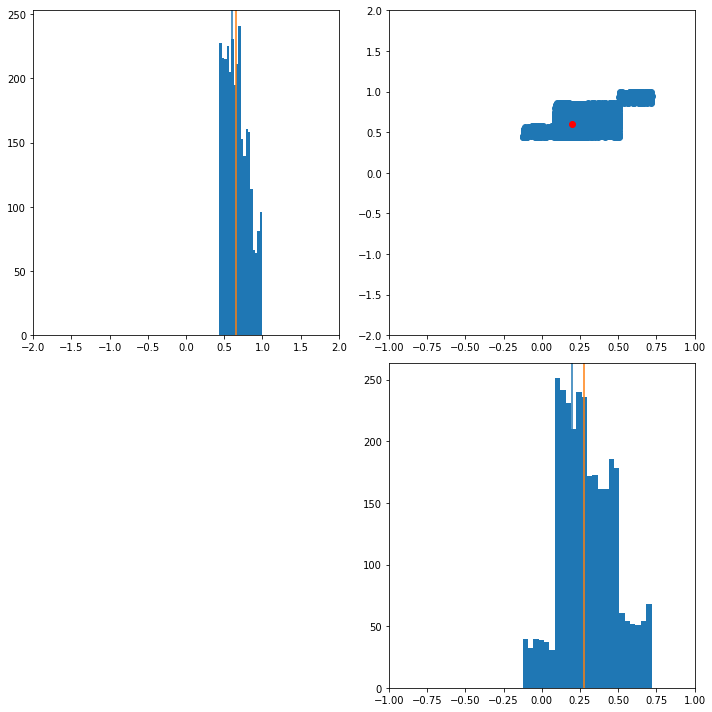

In [161]:
plot_posterior(post[-1])

## Perform parameter inference using BNN Regressor
Obs. Current implemented version do not perform proposal correction, i.e the ouput will be the proposal posterior.
Current implementation does not use early stopping

In [8]:
from sciope.inference.bnn_inference import BNNRegressor

In [9]:
bnn = BNNRegressor(obs_data, simulator, prior, verbose=True)

In [10]:
proposal_posterior, samples = bnn.infer(num_samples=1000, num_rounds=6, chunk_size=100)

starting round 0
data shape:  (10, 100, 1, 1, 100)
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
conv1d_flipout (Conv1DFlipou (None, 100, 25)           275       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 25)            0         
_________________________________________________________________
conv1d_flipout_1 (Conv1DFlip (None, 10, 6)             1506      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 6)              0         
_________________________________________

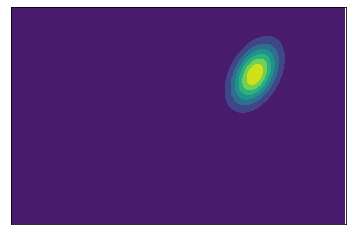

In [15]:
from tensorflow_probability import distributions as tfd

fig = plt.figure()

x, y = np.mgrid[-2:2:.01, -1:1:.01]
pos = np.dstack((x, y))

rv = tfd.MultivariateNormalTriL(loc=proposal_posterior.m, 
                                     scale_tril=tf.linalg.cholesky(proposal_posterior.S))

plt.contourf(x, y, rv.prob(pos))
plt.xlim(-2,2)
plt.ylim(-1,1)
plt.yticks([])
plt.xticks([])

plt.show()